In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%autoreload # When utils.py is updated
#from utils_unet_resunet import *
from ops import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from model.callbacks import UpdateWeights
from model.models import Model_4
from model.losses import WBCE
import matplotlib.pyplot as plt
import time
import tensorflow as tf


In [3]:
root_path = 'imgs/' 

In [4]:
# Define data type (L8-Landsat8, S2-Sentinel2, S1-Sentinel1)
img_type = 'FUSION'

if img_type == 'FUSION':
    image_array = np.load(root_path+'New_Images/fus_stack.npy')
    

if img_type == 'OPT':
    image_array = np.load(root_path+'New_Images/opt_stack.npy')
    
    
if img_type == 'SAR':
    image_array = np.load(root_path+'New_Images/sar_stack.npy')
print('Image stack:', image_array.shape)

final_mask1 = np.load(root_path+'New_Images/'+'final_mask1.npy')
print('Labels stack:', final_mask1.shape)



Image stack: (10000, 7000, 24)
Labels stack: (10000, 7000)


In [5]:
lim_x = 10000
lim_y = 7000
image_array = image_array[:lim_x, :lim_y, :]
final_mask1 = final_mask1[:lim_x, :lim_y]
h_, w_, channels = image_array.shape

mask:  (10000, 7000)
image stack:  (10000, 7000, 24)
ref : (10000, 7000)


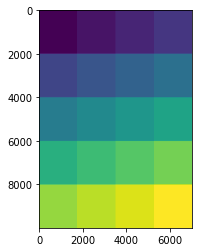

In [6]:
# Create tile mask
mask_tiles = create_mask(final_mask1.shape[0], final_mask1.shape[1], grid_size=(5, 4))
image_array = image_array[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
final_mask1 = final_mask1[:mask_tiles.shape[0], :mask_tiles.shape[1]]

print('mask: ',mask_tiles.shape)
print('image stack: ', image_array.shape)
print('ref :', final_mask1.shape)
plt.imshow(mask_tiles)

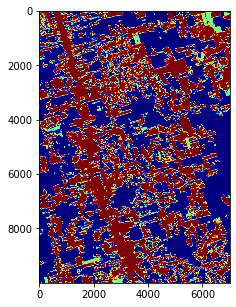

In [7]:
plt.figure(figsize=(10,5))
plt.imshow(final_mask1, cmap = 'jet')

In [8]:
# Define tiles for training, validation, and test sets
tiles_tr = [1,3,5,8,11,13,14,20]
tiles_val = [6,19]
tiles_ts = (list(set(np.arange(20)+1)-set(tiles_tr)-set(tiles_val)))

mask_tr_val = np.zeros((mask_tiles.shape)).astype('float32')
# Training and validation mask
for tr_ in tiles_tr:
    mask_tr_val[mask_tiles == tr_] = 1

for val_ in tiles_val:
    mask_tr_val[mask_tiles == val_] = 2

mask_amazon_ts = np.zeros((mask_tiles.shape)).astype('float32')
for ts_ in tiles_ts:
    mask_amazon_ts[mask_tiles == ts_] = 1

In [9]:
# Create ixd image to extract patches
overlap = 0.7
patch_size = 128
batch_size = 32
im_idx = create_idx_image(final_mask1)

patches_idx = extract_patches(im_idx, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1,patch_size, patch_size) #índice do pixel de cada patch
patches_mask = extract_patches(mask_tr_val, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1, patch_size, patch_size) #1 se pixel for de treinamento 2 se for val
del im_idx

In [10]:
# Selecting index trn val and test patches idx
idx_trn = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==patch_size**2)) #extrai apenas idx dos patches com todos os valores == 1 (train)
idx_val = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==2*patch_size**2)) #extrai apenas idx dos patches com todos os valores == 2 (val)
del patches_mask

patches_idx_trn = patches_idx[idx_trn]
patches_idx_val = patches_idx[idx_val]
del idx_trn, idx_val

print('Number of training patches:  ', len(patches_idx_trn), 'Number of validation patches', len(patches_idx_val))

Number of training patches:   17110 Number of validation patches 4116


In [11]:
# Extract patches with at least 2% of deforestation class
X_train = retrieve_idx_percentage(final_mask1, patches_idx_trn, patch_size, pertentage = 2)
X_valid = retrieve_idx_percentage(final_mask1, patches_idx_val, patch_size, pertentage = 2)
print(X_train.shape, X_valid.shape)
del patches_idx_trn, patches_idx_val

(1158, 128, 128) (341, 128, 128)


In [12]:
train_datagen = ImageDataGenerator(horizontal_flip = True,
                                   vertical_flip = True)
valid_datagen = ImageDataGenerator(horizontal_flip = True, 
                                   vertical_flip = True)

Y_train = np.zeros_like(X_train)
Y_valid = np.zeros_like(X_valid)

train_gen = train_datagen.flow(np.expand_dims(X_train, axis = -1), Y_train,
                              batch_size=batch_size,
                              shuffle=True)

valid_gen = valid_datagen.flow(np.expand_dims(X_valid, axis = -1), Y_valid,
                              batch_size=batch_size,
                              shuffle=False)

number_class = 3


In [13]:
def batch_generator(batches, image, reference, target_size, number_class):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    image = image.reshape(-1, image.shape[-1])
    reference = reference.reshape(final_mask1.shape[0]*final_mask1.shape[1])
    while True:
        batch_x, _ = next(batches)
        batch_x = np.squeeze(batch_x.astype('int64'))
        #print(batch_x.shape)
        batch_img = np.zeros((batch_x.shape[0], target_size, target_size, image.shape[-1]))
        batch_ref = np.zeros((batch_x.shape[0], target_size, target_size, number_class))
        
        for i in range(batch_x.shape[0]):
            if np.random.rand()>0.5:
                batch_x[i] = np.rot90(batch_x[i], 1)
            batch_img[i] = image[batch_x[i]] 
            batch_ref[i] = to_categorical(reference[batch_x[i]] , number_class)
                       
        yield (batch_img, batch_ref)

In [14]:
train_gen_crops = batch_generator(train_gen, image_array, final_mask1, patch_size, number_class)
valid_gen_crops = batch_generator(valid_gen, image_array, final_mask1, patch_size, number_class)

In [15]:
exp = 3
path_exp = root_path+'experiments/exp'+str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)

In [16]:
# Define model
input_shape = (patch_size, patch_size, channels)
nb_filters = [32, 64, 128]

method = 'unet'
n_opt_layers = 20
model = Model_4(nb_filters, number_class, n_opt_layers)

In [17]:
# Parameters of the model
weights = [0.2, 0.8, 0]
adam = Adam(lr = 1e-3 , beta_1=0.9)
#loss = weighted_categorical_crossentropy(weights)
loss = WBCE(weights = weights)
#loss = WBCE(weights = weights, class_indexes = [0, 1])


In [18]:
metrics_all = []
times=5
for tm in range(0,times):
    print('time: ', tm)

    rows = patch_size
    cols = patch_size
    adam = Adam(lr = 1e-3 , beta_1=0.9)
    
    #loss = weighted_categorical_crossentropy(weights)
    loss = WBCE(weights = weights)
    
    model = Model_4(nb_filters, number_class, n_opt_layers)
    model.build((None,)+input_shape)
    
    model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
    model.summary()

    
    # train the model
    start_training = time.time()
    
    #train OPT
    earlystop = EarlyStopping(monitor='val_opt_loss', min_delta=0.0001, patience=5, verbose=1, mode='min', restore_best_weights=True)
    callbacks_list = [earlystop]
    model.set_loss_streams([True, False, False])
    history = model.fit(train_gen_crops,
                              steps_per_epoch=(len(X_train)//train_gen.batch_size)+1,
                              validation_data=valid_gen_crops,
                              validation_steps=(len(X_valid)//valid_gen.batch_size)+1,
                              epochs=100,
                              callbacks=callbacks_list)
    
    #train SAR
    model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
    earlystop = EarlyStopping(monitor='val_sar_loss', min_delta=0.0001, patience=5, verbose=1, mode='min', restore_best_weights=True)
    callbacks_list = [earlystop]
    model.set_loss_streams([False, True, False])
    history = model.fit(train_gen_crops,
                              steps_per_epoch=(len(X_train)//train_gen.batch_size)+1,
                              validation_data=valid_gen_crops,
                              validation_steps=(len(X_valid)//valid_gen.batch_size)+1,
                              epochs=100,
                              callbacks=callbacks_list)
    
    #train FUS
    model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
    earlystop = EarlyStopping(monitor='val_fus_loss', min_delta=0.0001, patience=5, verbose=1, mode='min')
    updateWeights = UpdateWeights()
    checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_fus_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
    callbacks_list = [earlystop, checkpoint, updateWeights]
    model.set_loss_streams([True, True, True])
    history = model.fit(train_gen_crops,
                              steps_per_epoch=(len(X_train)//train_gen.batch_size)+1,
                              validation_data=valid_gen_crops,
                              validation_steps=(len(X_valid)//valid_gen.batch_size)+1,
                              epochs=100,
                              callbacks=callbacks_list)
    
    end_training = time.time() - start_training
    metrics_all.append(end_training)
    del model, history

time:  0
Model: "model_4_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
opt_encoder (UNET_Encoder)   multiple                  540896    
_________________________________________________________________
sar_encoder (UNET_Encoder)   multiple                  536288    
_________________________________________________________________
opt_decoder (UNET_Decoder)   multiple                  332000    
_________________________________________________________________
sar_decoder (UNET_Decoder)   multiple                  332000    
_________________________________________________________________
fus_cross (CrossFusion)      multiple                  518531    
_________________________________________________________________
opt_classifier (Classifier)  multiple                  195       
_________________________________________________________________
sar_classifier (Classifier)  multiple           

Epoch 8/100
37/37 [==============================] - 6s 153ms/step - opt_accuracy: 0.8935 - sar_accuracy: 0.8251 - fus_accuracy: 0.6052 - opt_loss: 0.0604 - sar_loss: 0.0989 - fus_loss: 5.4021 - loss: 5.5614 - val_opt_accuracy: 0.8664 - val_sar_accuracy: 0.8044 - val_fus_accuracy: 0.6033 - val_opt_loss: 0.0903 - val_sar_loss: 0.1244 - val_fus_loss: 2.1098 - val_loss: 2.3245
Epoch 9/100
37/37 [==============================] - 6s 154ms/step - opt_accuracy: 0.8929 - sar_accuracy: 0.8288 - fus_accuracy: 0.6073 - opt_loss: 0.0608 - sar_loss: 0.0967 - fus_loss: 5.4010 - loss: 5.5584 - val_opt_accuracy: 0.8666 - val_sar_accuracy: 0.7973 - val_fus_accuracy: 0.6041 - val_opt_loss: 0.0902 - val_sar_loss: 0.1146 - val_fus_loss: 2.0941 - val_loss: 2.2988
Epoch 10/100
37/37 [==============================] - 6s 163ms/step - opt_accuracy: 0.8943 - sar_accuracy: 0.8337 - fus_accuracy: 0.6035 - opt_loss: 0.0603 - sar_loss: 0.0959 - fus_loss: 5.4114 - loss: 5.5676 - val_opt_accuracy: 0.8670 - val_sar_

37/37 [==============================] - 13s 360ms/step - opt_accuracy: 0.9022 - sar_accuracy: 0.8510 - fus_accuracy: 0.8405 - opt_loss: 0.0542 - sar_loss: 0.0810 - fus_loss: 0.1612 - loss: 0.2964 - val_opt_accuracy: 0.8652 - val_sar_accuracy: 0.8146 - val_fus_accuracy: 0.8436 - val_opt_loss: 0.1150 - val_sar_loss: 0.1210 - val_fus_loss: 0.1403 - val_loss: 0.3763

Epoch 00010: val_fus_loss did not improve from 0.13083
Epoch 11/100
37/37 [==============================] - 13s 364ms/step - opt_accuracy: 0.9028 - sar_accuracy: 0.8583 - fus_accuracy: 0.8528 - opt_loss: 0.0526 - sar_loss: 0.0766 - fus_loss: 0.1455 - loss: 0.2746 - val_opt_accuracy: 0.8552 - val_sar_accuracy: 0.8000 - val_fus_accuracy: 0.7658 - val_opt_loss: 0.1279 - val_sar_loss: 0.1295 - val_fus_loss: 0.1972 - val_loss: 0.4546

Epoch 00011: val_fus_loss did not improve from 0.13083
Epoch 00011: early stopping
time:  1
Model: "model_4_2"
_________________________________________________________________
Layer (type)         

37/37 [==============================] - 6s 155ms/step - opt_accuracy: 0.8741 - sar_accuracy: 0.8366 - fus_accuracy: 0.5601 - opt_loss: 0.0785 - sar_loss: 0.0915 - fus_loss: 5.6348 - loss: 5.8048 - val_opt_accuracy: 0.8400 - val_sar_accuracy: 0.8090 - val_fus_accuracy: 0.5191 - val_opt_loss: 0.0945 - val_sar_loss: 0.1128 - val_fus_loss: 2.0685 - val_loss: 2.2758
Restoring model weights from the end of the best epoch.
Epoch 00010: early stopping
Epoch 1/100
37/37 [==============================] - 16s 375ms/step - opt_accuracy: 0.8767 - sar_accuracy: 0.8083 - fus_accuracy: 0.6831 - opt_loss: 0.0756 - sar_loss: 0.1086 - fus_loss: 3.9613 - loss: 4.1456 - val_opt_accuracy: 0.8530 - val_sar_accuracy: 0.8044 - val_fus_accuracy: 0.8127 - val_opt_loss: 0.0939 - val_sar_loss: 0.1239 - val_fus_loss: 0.3516 - val_loss: 0.5694

Epoch 00001: val_fus_loss improved from inf to 0.35156, saving model to imgs/experiments/exp3/models\unet_1.h5
Epoch 2/100
37/37 [==============================] - 13s 360m

Epoch 7/100
37/37 [==============================] - 6s 159ms/step - opt_accuracy: 0.8961 - sar_accuracy: 0.6351 - fus_accuracy: 0.5713 - opt_loss: 0.0584 - sar_loss: 0.1991 - fus_loss: 5.4482 - loss: 5.7057 - val_opt_accuracy: 0.8663 - val_sar_accuracy: 0.6307 - val_fus_accuracy: 0.4947 - val_opt_loss: 0.0920 - val_sar_loss: 0.1963 - val_fus_loss: 2.0767 - val_loss: 2.3651
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
Epoch 1/100
37/37 [==============================] - 8s 169ms/step - opt_accuracy: 0.8868 - sar_accuracy: 0.7549 - fus_accuracy: 0.5802 - opt_loss: 0.0672 - sar_loss: 0.1374 - fus_loss: 5.5018 - loss: 5.7064 - val_opt_accuracy: 0.8643 - val_sar_accuracy: 0.7822 - val_fus_accuracy: 0.5250 - val_opt_loss: 0.0922 - val_sar_loss: 0.1191 - val_fus_loss: 1.2293 - val_loss: 1.4406
Epoch 2/100
37/37 [==============================] - 6s 158ms/step - opt_accuracy: 0.8869 - sar_accuracy: 0.7898 - fus_accuracy: 0.5747 - opt_loss: 0.0651 - sar_l

37/37 [==============================] - 13s 365ms/step - opt_accuracy: 0.8954 - sar_accuracy: 0.8377 - fus_accuracy: 0.8219 - opt_loss: 0.0608 - sar_loss: 0.0940 - fus_loss: 0.2940 - loss: 0.4488 - val_opt_accuracy: 0.8591 - val_sar_accuracy: 0.8147 - val_fus_accuracy: 0.8074 - val_opt_loss: 0.1029 - val_sar_loss: 0.1131 - val_fus_loss: 0.1506 - val_loss: 0.3666

Epoch 00006: val_fus_loss did not improve from 0.14514
Epoch 7/100
37/37 [==============================] - 13s 363ms/step - opt_accuracy: 0.8981 - sar_accuracy: 0.8368 - fus_accuracy: 0.8263 - opt_loss: 0.0581 - sar_loss: 0.0943 - fus_loss: 0.2295 - loss: 0.3819 - val_opt_accuracy: 0.8549 - val_sar_accuracy: 0.8114 - val_fus_accuracy: 0.7755 - val_opt_loss: 0.0988 - val_sar_loss: 0.1224 - val_fus_loss: 0.1370 - val_loss: 0.3582

Epoch 00007: val_fus_loss improved from 0.14514 to 0.13702, saving model to imgs/experiments/exp3/models\unet_2.h5
Epoch 8/100
37/37 [==============================] - 14s 366ms/step - opt_accuracy: 

37/37 [==============================] - 6s 162ms/step - opt_accuracy: 0.8873 - sar_accuracy: 0.7827 - fus_accuracy: 0.6356 - opt_loss: 0.0670 - sar_loss: 0.1278 - fus_loss: 5.8396 - loss: 6.0344 - val_opt_accuracy: 0.8623 - val_sar_accuracy: 0.7687 - val_fus_accuracy: 0.6257 - val_opt_loss: 0.0909 - val_sar_loss: 0.1241 - val_fus_loss: 2.5931 - val_loss: 2.8081
Epoch 3/100
37/37 [==============================] - 6s 164ms/step - opt_accuracy: 0.8841 - sar_accuracy: 0.7891 - fus_accuracy: 0.6231 - opt_loss: 0.0671 - sar_loss: 0.1221 - fus_loss: 5.8492 - loss: 6.0384 - val_opt_accuracy: 0.8623 - val_sar_accuracy: 0.7861 - val_fus_accuracy: 0.6017 - val_opt_loss: 0.0910 - val_sar_loss: 0.1234 - val_fus_loss: 3.5051 - val_loss: 3.7195
Epoch 4/100
37/37 [==============================] - 6s 163ms/step - opt_accuracy: 0.8859 - sar_accuracy: 0.8077 - fus_accuracy: 0.6198 - opt_loss: 0.0679 - sar_loss: 0.1115 - fus_loss: 5.8435 - loss: 6.0229 - val_opt_accuracy: 0.8623 - val_sar_accuracy: 0.7


Epoch 00004: val_fus_loss did not improve from 0.14379
Epoch 5/100
37/37 [==============================] - 14s 373ms/step - opt_accuracy: 0.8932 - sar_accuracy: 0.8414 - fus_accuracy: 0.8352 - opt_loss: 0.0604 - sar_loss: 0.0899 - fus_loss: 0.7012 - loss: 0.8515 - val_opt_accuracy: 0.8667 - val_sar_accuracy: 0.8126 - val_fus_accuracy: 0.8176 - val_opt_loss: 0.1058 - val_sar_loss: 0.1239 - val_fus_loss: 0.1518 - val_loss: 0.3816

Epoch 00005: val_fus_loss did not improve from 0.14379
Epoch 6/100
37/37 [==============================] - 14s 371ms/step - opt_accuracy: 0.8974 - sar_accuracy: 0.8413 - fus_accuracy: 0.8322 - opt_loss: 0.0577 - sar_loss: 0.0879 - fus_loss: 0.4877 - loss: 0.6333 - val_opt_accuracy: 0.8520 - val_sar_accuracy: 0.8172 - val_fus_accuracy: 0.7837 - val_opt_loss: 0.0981 - val_sar_loss: 0.1065 - val_fus_loss: 0.1477 - val_loss: 0.3523

Epoch 00006: val_fus_loss did not improve from 0.14379
Epoch 7/100
37/37 [==============================] - 14s 371ms/step - opt_ac

Epoch 3/100
37/37 [==============================] - 6s 173ms/step - opt_accuracy: 0.8939 - sar_accuracy: 0.7976 - fus_accuracy: 0.6323 - opt_loss: 0.0612 - sar_loss: 0.1201 - fus_loss: 5.6266 - loss: 5.8079 - val_opt_accuracy: 0.8614 - val_sar_accuracy: 0.7963 - val_fus_accuracy: 0.7183 - val_opt_loss: 0.0946 - val_sar_loss: 0.1192 - val_fus_loss: 3.5760 - val_loss: 3.7898
Epoch 4/100
37/37 [==============================] - 6s 171ms/step - opt_accuracy: 0.8953 - sar_accuracy: 0.8018 - fus_accuracy: 0.6384 - opt_loss: 0.0582 - sar_loss: 0.1118 - fus_loss: 5.5807 - loss: 5.7507 - val_opt_accuracy: 0.8612 - val_sar_accuracy: 0.7912 - val_fus_accuracy: 0.7568 - val_opt_loss: 0.0947 - val_sar_loss: 0.1196 - val_fus_loss: 2.7274 - val_loss: 2.9417
Epoch 5/100
37/37 [==============================] - 6s 172ms/step - opt_accuracy: 0.8952 - sar_accuracy: 0.8180 - fus_accuracy: 0.6339 - opt_loss: 0.0606 - sar_loss: 0.1083 - fus_loss: 5.5856 - loss: 5.7545 - val_opt_accuracy: 0.8612 - val_sar_a


Epoch 00010: val_fus_loss did not improve from 0.13059
Epoch 00010: early stopping


In [19]:
# Test loop
time_ts = []
n_pool = 3
n_rows = 20#5
n_cols = 16#4
rows, cols = image_array.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_array, pad_width=npad, mode='reflect')

h, w, c = image1_pad.shape
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

input_shape=(patch_size_rows,patch_size_cols, c)

#if method == 'unet':
#   new_model = build_unet(input_shape, nb_filters, number_class)

#if method == 'resunet':
#   new_model = build_resunet(input_shape, nb_filters, number_class)

new_model = Model_4(nb_filters, number_class, n_opt_layers)
new_model.build((None,)+input_shape)
adam = Adam(lr = 1e-3 , beta_1=0.9)
loss = WBCE(weights = weights)
#loss = weighted_categorical_crossentropy(weights)
new_model.compile(optimizer=adam, loss=loss, metrics=['accuracy'], run_eagerly=True)

for tm in range(0,times):
    print('time: ', tm)
    #model = load_model(path_models+ '/' + method +'_'+str(tm)+'.h5', compile=False)
    
    #for l in range(1, len(model.layers)):
    #    new_model.layers[l].set_weights(model.layers[l].get_weights())
    new_model.load_weights(path_models+ '/' + method +'_'+str(tm)+'.h5')
    
    start_test = time.time()
    patch_opt = []
    patch_sar = []
    patch_fus = []
    patch_comb = []
    
    for i in range(0,num_patches_y):
        for j in range(0,num_patches_x):
            patch = image1_pad[patch_size_rows*j:patch_size_rows*(j+1), patch_size_cols*i:patch_size_cols*(i+1), :]
            pred_opt, pred_sar, pred_fus, pred_comb = new_model.predict(np.expand_dims(patch, axis=0))
            del patch 
            patch_opt.append(pred_opt[:,:,:,1])
            patch_sar.append(pred_sar[:,:,:,1])
            patch_fus.append(pred_fus[:,:,:,1])
            patch_comb.append(pred_comb[:,:,:,1])
            del pred_opt, pred_sar, pred_fus, pred_comb
    end_test =  time.time() - start_test

    patches_pred_opt = np.asarray(patch_opt).astype(np.float32)
    patches_pred_sar = np.asarray(patch_sar).astype(np.float32)
    patches_pred_fus = np.asarray(patch_fus).astype(np.float32)
    patches_pred_comb = np.asarray(patch_comb).astype(np.float32)

    prob_recontructed_opt = pred_reconctruct(h, w, num_patches_x, num_patches_y, patch_size_rows, patch_size_cols, patches_pred_opt)
    prob_recontructed_sar = pred_reconctruct(h, w, num_patches_x, num_patches_y, patch_size_rows, patch_size_cols, patches_pred_sar)
    prob_recontructed_fus = pred_reconctruct(h, w, num_patches_x, num_patches_y, patch_size_rows, patch_size_cols, patches_pred_fus)
    prob_recontructed_comb = pred_reconctruct(h, w, num_patches_x, num_patches_y, patch_size_rows, patch_size_cols, patches_pred_comb)

    del patches_pred_opt, patches_pred_sar, patches_pred_fus, patches_pred_comb
    np.save(path_maps+'/'+'prob_opt_'+str(tm)+'.npy',prob_recontructed_opt) 
    np.save(path_maps+'/'+'prob_sar_'+str(tm)+'.npy',prob_recontructed_sar) 
    np.save(path_maps+'/'+'prob_fus_'+str(tm)+'.npy',prob_recontructed_fus) 
    np.save(path_maps+'/'+'prob_comb_'+str(tm)+'.npy',prob_recontructed_comb) 

    time_ts.append(end_test)
    del prob_recontructed_opt, prob_recontructed_sar, prob_recontructed_fus, prob_recontructed_comb
    #del model
time_ts_array = np.asarray(time_ts)
# Save test time
np.save(path_exp+'/metrics_ts.npy', time_ts_array)


-80.0 -40.0
time:  0
time:  1
time:  2
time:  3
time:  4


In [20]:
# Compute mean of the tm predictions maps
prob_rec_opt = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times))
prob_rec_sar = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times))
prob_rec_fus = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times))
prob_rec_comb = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times))

for tm in range (0, times):
    print(tm)
    prob_rec_opt[:,:,tm] = np.load(path_maps+'/'+'prob_opt_'+str(tm)+'.npy').astype(np.float32)
    prob_rec_sar[:,:,tm] = np.load(path_maps+'/'+'prob_sar_'+str(tm)+'.npy').astype(np.float32)
    prob_rec_fus[:,:,tm] = np.load(path_maps+'/'+'prob_fus_'+str(tm)+'.npy').astype(np.float32)
    prob_rec_comb[:,:,tm] = np.load(path_maps+'/'+'prob_comb_'+str(tm)+'.npy').astype(np.float32)

mean_prob_opt = np.mean(prob_rec_opt, axis = -1)
mean_prob_sar = np.mean(prob_rec_sar, axis = -1)
mean_prob_fus = np.mean(prob_rec_fus, axis = -1)
mean_prob_comb = np.mean(prob_rec_comb, axis = -1)

np.save(path_maps+'/prob_mean_opt.npy', mean_prob_opt)
np.save(path_maps+'/prob_mean_sar.npy', mean_prob_sar)
np.save(path_maps+'/prob_mean_fus.npy', mean_prob_fus)
np.save(path_maps+'/prob_mean_comb.npy', mean_prob_comb)

0
1
2
3
4


(-0.5, 6999.5, 9999.5, -0.5)

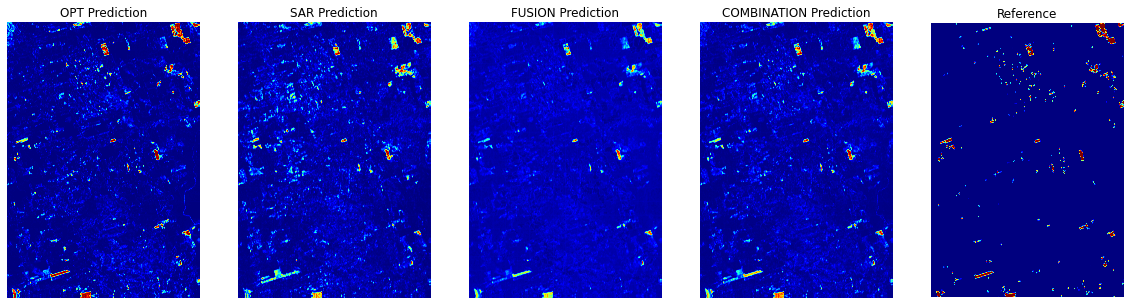

In [21]:
# Plot mean map and reference
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(151)
plt.title('OPT Prediction')
ax1.imshow(mean_prob_opt, cmap ='jet')
ax1.axis('off')

ax1 = fig.add_subplot(152)
plt.title('SAR Prediction')
ax1.imshow(mean_prob_sar, cmap ='jet')
ax1.axis('off')

ax1 = fig.add_subplot(153)
plt.title('FUSION Prediction')
ax1.imshow(mean_prob_fus, cmap ='jet')
ax1.axis('off')

ax1 = fig.add_subplot(154)
plt.title('COMBINATION Prediction')
ax1.imshow(mean_prob_comb, cmap ='jet')
ax1.axis('off')

ax2 = fig.add_subplot(155)
plt.title('Reference')
ax2.imshow(tf.keras.utils.to_categorical(final_mask1, 3)[:,:,1], cmap ='jet')
ax2.axis('off')

In [22]:
t0 = time.time()
mean_prob_opt = mean_prob_opt[:final_mask1.shape[0], :final_mask1.shape[1]]
ref1 = np.ones_like(final_mask1).astype(np.float32)

ref1 [final_mask1 == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = final_mask1==1

Npoints = 4

Pmax_opt = np.max(mean_prob_opt[GTTruePositives * TileMask ==1])
ProbList_opt = np.linspace(Pmax_opt,0,Npoints)

metrics_opt = metrics_AP(ProbList_opt, mean_prob_opt, final_mask1, mask_amazon_ts, 625, 4)
print(f'tempo: {time.time()-t0}')

tempo: 112.91221523284912


In [23]:
# Computing metrics
t0 = time.time()
mean_prob_opt = mean_prob_opt[:final_mask1.shape[0], :final_mask1.shape[1]]
mean_prob_sar = mean_prob_sar[:final_mask1.shape[0], :final_mask1.shape[1]]
mean_prob_fus = mean_prob_fus[:final_mask1.shape[0], :final_mask1.shape[1]]
mean_prob_comb = mean_prob_comb[:final_mask1.shape[0], :final_mask1.shape[1]]

ref1 = np.ones_like(final_mask1).astype(np.float32)

ref1 [final_mask1 == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = final_mask1==1
    
Npoints = 50

Pmax_opt = np.max(mean_prob_opt[GTTruePositives * TileMask ==1])
ProbList_opt = np.linspace(Pmax_opt,0,Npoints)

Pmax_sar = np.max(mean_prob_sar[GTTruePositives * TileMask ==1])
ProbList_sar = np.linspace(Pmax_sar,0,Npoints)

Pmax_fus = np.max(mean_prob_fus[GTTruePositives * TileMask ==1])
ProbList_fus = np.linspace(Pmax_fus,0,Npoints)

Pmax_comb = np.max(mean_prob_comb[GTTruePositives * TileMask ==1])
ProbList_comb = np.linspace(Pmax_comb,0,Npoints)


from multiprocessing.pool import Pool
pool = Pool(processes=4)

async_result_opt = pool.apply_async(matrics_AA_recall, (ProbList_opt, mean_prob_opt, final_mask1, mask_amazon_ts, 625))
async_result_sar = pool.apply_async(matrics_AA_recall, (ProbList_sar, mean_prob_sar, final_mask1, mask_amazon_ts, 625))
async_result_fus = pool.apply_async(matrics_AA_recall, (ProbList_fus, mean_prob_fus, final_mask1, mask_amazon_ts, 625))
async_result_comb = pool.apply_async(matrics_AA_recall, (ProbList_comb, mean_prob_comb, final_mask1, mask_amazon_ts, 625))

metrics_opt = async_result_opt.get()
metrics_sar = async_result_sar.get()
metrics_fus = async_result_fus.get()
metrics_comb = async_result_comb.get()
    
#metrics_opt = matrics_AA_recall(ProbList_opt, mean_prob_opt, final_mask1, mask_amazon_ts, 625)
#metrics_sar = matrics_AA_recall(ProbList_sar, mean_prob_sar, final_mask1, mask_amazon_ts, 625)
#metrics_fus = matrics_AA_recall(ProbList_fus, mean_prob_fus, final_mask1, mask_amazon_ts, 625)
#metrics_comb = matrics_AA_recall(ProbList_comb, mean_prob_comb, final_mask1, mask_amazon_ts, 625)

np.save(path_exp+'/acc_metrics_opt.npy',metrics_opt)
np.save(path_exp+'/acc_metrics_sar.npy',metrics_sar)
np.save(path_exp+'/acc_metrics_fus.npy',metrics_fus)
np.save(path_exp+'/acc_metrics_comb.npy',metrics_comb)
print(f'tempo: {time.time()-t0}')

tempo: 3856.585215330124


In [24]:
# Complete NaN values
metrics_copy_opt = metrics_opt.copy()
metrics_copy_opt = complete_nan_values(metrics_copy_opt)

metrics_copy_sar = metrics_sar.copy()
metrics_copy_sar = complete_nan_values(metrics_copy_sar)

metrics_copy_fus = metrics_fus.copy()
metrics_copy_fus = complete_nan_values(metrics_copy_fus)

metrics_copy_comb = metrics_comb.copy()
metrics_copy_comb = complete_nan_values(metrics_copy_comb)

OPT mAP 0.93560563849642
SAR mAP 0.8458477694511687
FUSION mAP 0.9433954080591649
COMBINATION mAP 0.9449147411006635


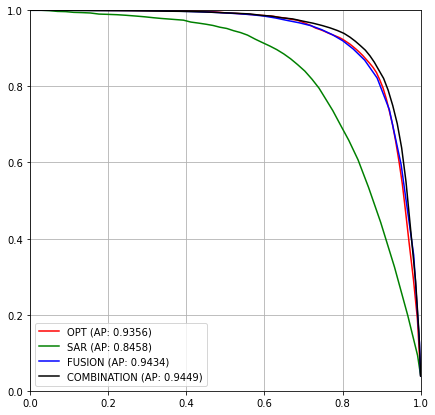

In [25]:
# Comput Mean Average Precision (mAP) score 
Recall_opt = metrics_copy_opt[:,0]
Precision_opt = metrics_copy_opt[:,1]
AA_opt = metrics_copy_opt[:,2]

Recall_sar = metrics_copy_sar[:,0]
Precision_sar = metrics_copy_sar[:,1]
AA_sar = metrics_copy_sar[:,2]

Recall_fus = metrics_copy_fus[:,0]
Precision_fus = metrics_copy_fus[:,1]
AA_fus = metrics_copy_fus[:,2]

Recall_comb = metrics_copy_comb[:,0]
Precision_comb = metrics_copy_comb[:,1]
AA_comb = metrics_copy_comb[:,2]
    
DeltaR_opt = Recall_opt[1:]-Recall_opt[:-1]
AP_opt = np.sum(Precision_opt[:-1]*DeltaR_opt)
print('OPT mAP', AP_opt)

DeltaR_sar = Recall_sar[1:]-Recall_sar[:-1]
AP_sar = np.sum(Precision_sar[:-1]*DeltaR_sar)
print('SAR mAP', AP_sar)

DeltaR_fus = Recall_fus[1:]-Recall_fus[:-1]
AP_fus = np.sum(Precision_fus[:-1]*DeltaR_fus)
print('FUSION mAP', AP_fus)

DeltaR_comb = Recall_comb[1:]-Recall_comb[:-1]
AP_comb = np.sum(Precision_comb[:-1]*DeltaR_comb)
print('COMBINATION mAP', AP_comb)

# Plot Recall vs. Precision curve
plt.figure(figsize=(7,7))
plt.plot(metrics_copy_opt[:,0],metrics_copy_opt[:,1], 'r-', label = f'OPT (AP: {AP_opt:.4f})')
plt.plot(metrics_copy_sar[:,0],metrics_copy_sar[:,1], 'g-', label = f'SAR (AP: {AP_sar:.4f})')
plt.plot(metrics_copy_fus[:,0],metrics_copy_fus[:,1], 'b-', label = f'FUSION (AP: {AP_fus:.4f})')
plt.plot(metrics_copy_comb[:,0],metrics_copy_comb[:,1], 'k-', label = f'COMBINATION (AP: {AP_comb:.4f})')
plt.legend(loc="lower left")
ax = plt.gca()
ax.set_ylim([0,1])
ax.set_xlim([0,1])
#plt.plot(metrics_copy[:,0],metrics_copy[:,2])
plt.grid()

In [26]:
# Computing metrics
t0 = time.time()
mean_prob_opt = mean_prob_opt[:final_mask1.shape[0], :final_mask1.shape[1]]
mean_prob_sar = mean_prob_sar[:final_mask1.shape[0], :final_mask1.shape[1]]
mean_prob_fus = mean_prob_fus[:final_mask1.shape[0], :final_mask1.shape[1]]
mean_prob_comb = mean_prob_comb[:final_mask1.shape[0], :final_mask1.shape[1]]

ref1 = np.ones_like(final_mask1).astype(np.float32)

ref1 [final_mask1 == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = final_mask1==1
    
Npoints = 50

Pmax_opt = np.max(mean_prob_opt[GTTruePositives * TileMask ==1])
ProbList_opt = np.linspace(Pmax_opt,0,Npoints)

Pmax_sar = np.max(mean_prob_sar[GTTruePositives * TileMask ==1])
ProbList_sar = np.linspace(Pmax_sar,0,Npoints)

Pmax_fus = np.max(mean_prob_fus[GTTruePositives * TileMask ==1])
ProbList_fus = np.linspace(Pmax_fus,0,Npoints)

Pmax_comb = np.max(mean_prob_comb[GTTruePositives * TileMask ==1])
ProbList_comb = np.linspace(Pmax_comb,0,Npoints)

metrics_opt = metrics_AP(ProbList_opt, mean_prob_opt, final_mask1, mask_amazon_ts, 625)
metrics_sar = metrics_AP(ProbList_sar, mean_prob_sar, final_mask1, mask_amazon_ts, 625)
metrics_fus = metrics_AP(ProbList_fus, mean_prob_fus, final_mask1, mask_amazon_ts, 625)
metrics_comb = metrics_AP(ProbList_comb, mean_prob_comb, final_mask1, mask_amazon_ts, 625)
    

np.save(path_exp+'/acc_metrics_opt.npy',metrics_opt)
np.save(path_exp+'/acc_metrics_sar.npy',metrics_sar)
np.save(path_exp+'/acc_metrics_fus.npy',metrics_fus)
np.save(path_exp+'/acc_metrics_comb.npy',metrics_comb)
print(f'tempo: {time.time()-t0}')

tempo: 2613.605808496475


In [29]:
np.array(metrics_opt)

array([[0.        ,        nan, 0.        ],
       [0.15649322, 1.        , 0.00327054],
       [0.28978993, 0.9991902 , 0.00610383],
       [0.3663607 , 0.99856719, 0.00769717],
       [0.42273486, 0.99782129, 0.00887811],
       [0.46755866, 0.99637381, 0.00983323],
       [0.50266375, 0.99304461, 0.01058994],
       [0.53228503, 0.99149326, 0.0112012 ],
       [0.55889591, 0.98932235, 0.01177894],
       [0.58271575, 0.98762991, 0.01229694],
       [0.60415164, 0.98569489, 0.01279263],
       [0.62229182, 0.98426431, 0.01318023],
       [0.63875395, 0.98137791, 0.01354766],
       [0.65432514, 0.97940286, 0.01390346],
       [0.66929545, 0.97602319, 0.01429   ],
       [0.68359386, 0.97411286, 0.01465703],
       [0.69679891, 0.96915556, 0.01504971],
       [0.70833777, 0.964173  , 0.01537229],
       [0.71984269, 0.95954591, 0.01571234],
       [0.73077684, 0.95333889, 0.01605497],
       [0.7411347 , 0.94980191, 0.01632731],
       [0.751546  , 0.9457042 , 0.01660691],
       [0.

In [30]:
# Complete NaN values
metrics_copy_opt = np.array(metrics_opt)
metrics_copy_opt = complete_nan_values(metrics_copy_opt)

metrics_copy_sar = np.array(metrics_sar)
metrics_copy_sar = complete_nan_values(metrics_copy_sar)

metrics_copy_fus = np.array(metrics_fus)
metrics_copy_fus = complete_nan_values(metrics_copy_fus)

metrics_copy_comb = np.array(metrics_comb)
metrics_copy_comb = complete_nan_values(metrics_copy_comb)

OPT mAP 0.93560563849642
SAR mAP 0.8458477694511687
FUSION mAP 0.9433954080591649
COMBINATION mAP 0.9449147411006635


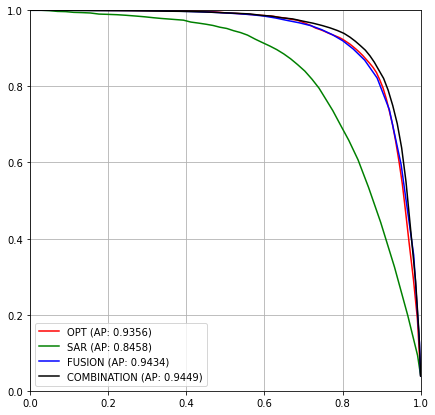

In [31]:
# Comput Mean Average Precision (mAP) score 
Recall_opt = metrics_copy_opt[:,0]
Precision_opt = metrics_copy_opt[:,1]
AA_opt = metrics_copy_opt[:,2]

Recall_sar = metrics_copy_sar[:,0]
Precision_sar = metrics_copy_sar[:,1]
AA_sar = metrics_copy_sar[:,2]

Recall_fus = metrics_copy_fus[:,0]
Precision_fus = metrics_copy_fus[:,1]
AA_fus = metrics_copy_fus[:,2]

Recall_comb = metrics_copy_comb[:,0]
Precision_comb = metrics_copy_comb[:,1]
AA_comb = metrics_copy_comb[:,2]
    
DeltaR_opt = Recall_opt[1:]-Recall_opt[:-1]
AP_opt = np.sum(Precision_opt[:-1]*DeltaR_opt)
print('OPT mAP', AP_opt)

DeltaR_sar = Recall_sar[1:]-Recall_sar[:-1]
AP_sar = np.sum(Precision_sar[:-1]*DeltaR_sar)
print('SAR mAP', AP_sar)

DeltaR_fus = Recall_fus[1:]-Recall_fus[:-1]
AP_fus = np.sum(Precision_fus[:-1]*DeltaR_fus)
print('FUSION mAP', AP_fus)

DeltaR_comb = Recall_comb[1:]-Recall_comb[:-1]
AP_comb = np.sum(Precision_comb[:-1]*DeltaR_comb)
print('COMBINATION mAP', AP_comb)

# Plot Recall vs. Precision curve
plt.figure(figsize=(7,7))
plt.plot(metrics_copy_opt[:,0],metrics_copy_opt[:,1], 'r-', label = f'OPT (AP: {AP_opt:.4f})')
plt.plot(metrics_copy_sar[:,0],metrics_copy_sar[:,1], 'g-', label = f'SAR (AP: {AP_sar:.4f})')
plt.plot(metrics_copy_fus[:,0],metrics_copy_fus[:,1], 'b-', label = f'FUSION (AP: {AP_fus:.4f})')
plt.plot(metrics_copy_comb[:,0],metrics_copy_comb[:,1], 'k-', label = f'COMBINATION (AP: {AP_comb:.4f})')
plt.legend(loc="lower left")
ax = plt.gca()
ax.set_ylim([0,1])
ax.set_xlim([0,1])
#plt.plot(metrics_copy[:,0],metrics_copy[:,2])
plt.grid()